In [4]:

import numpy as np
from multiprocessing import Pool
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable, Tuple


In [5]:
def two_arm_bandit_A(choice: int) -> int:
    probabilities = (0.1, 0.2)
    threshold = probabilities[choice - 1]
    return int(np.random.rand() < threshold)


def two_arm_bandit_B(choice: int) -> int:
    probabilities = (0.8, 0.9)
    threshold = probabilities[choice - 1]
    return int(np.random.rand() < threshold)

In [6]:
def epsilon_greedy(bandit_func: Callable[[int], int], epsilon: float, num_actions: int, num_iterations: int, alpha: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    Q = np.zeros(num_actions)
    N = np.zeros(num_actions)
    rewards = np.zeros(num_iterations)
    actions = np.zeros(num_iterations, dtype=int)

    for i in range(num_iterations):
        if np.random.random() < epsilon:
            action = np.random.randint(1, num_actions + 1)
        else:
            action = np.argmax(Q) + 1

        reward = bandit_func(action)

        N[action - 1] += 1
        Q[action - 1] += alpha * (reward - Q[action - 1])

        rewards[i] = reward
        actions[i] = action

        if i > 1000 and np.abs(np.mean(rewards[i-1000:i]) - np.mean(rewards[i-2000:i-1000])) < 1e-4:
            return Q, rewards[:i+1], actions[:i+1]

    return Q, rewards, actions

In [7]:
def run_experiment(params: Tuple[Callable[[int], int], float, int, int, float]) -> Tuple[np.ndarray, np.ndarray]:
    bandit_func, epsilon, num_actions, num_iterations, alpha = params
    Q, rewards, _ = epsilon_greedy(bandit_func, epsilon, num_actions, num_iterations, alpha)
    return Q, rewards

In [8]:
def pad_rewards(rewards_list: list, max_length: int) -> np.ndarray:
    return np.array([np.pad(r, (0, max_length - len(r)), 'constant', constant_values=np.nan) for r in rewards_list])

Simulating A:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Simulating B: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]



=== Summary for Env A ===
Mean Q: [0.04991813 0.17207355]
Avg Reward: 0.18185721100582633
Best Option: 2
Final Cumulative Avg: 0.09533376679670566

=== Summary for Env B ===
Mean Q: [0.71351034 0.80588369]
Avg Reward: 0.878424608641083
Best Option: 2
Final Cumulative Avg: 0.5826441631504923


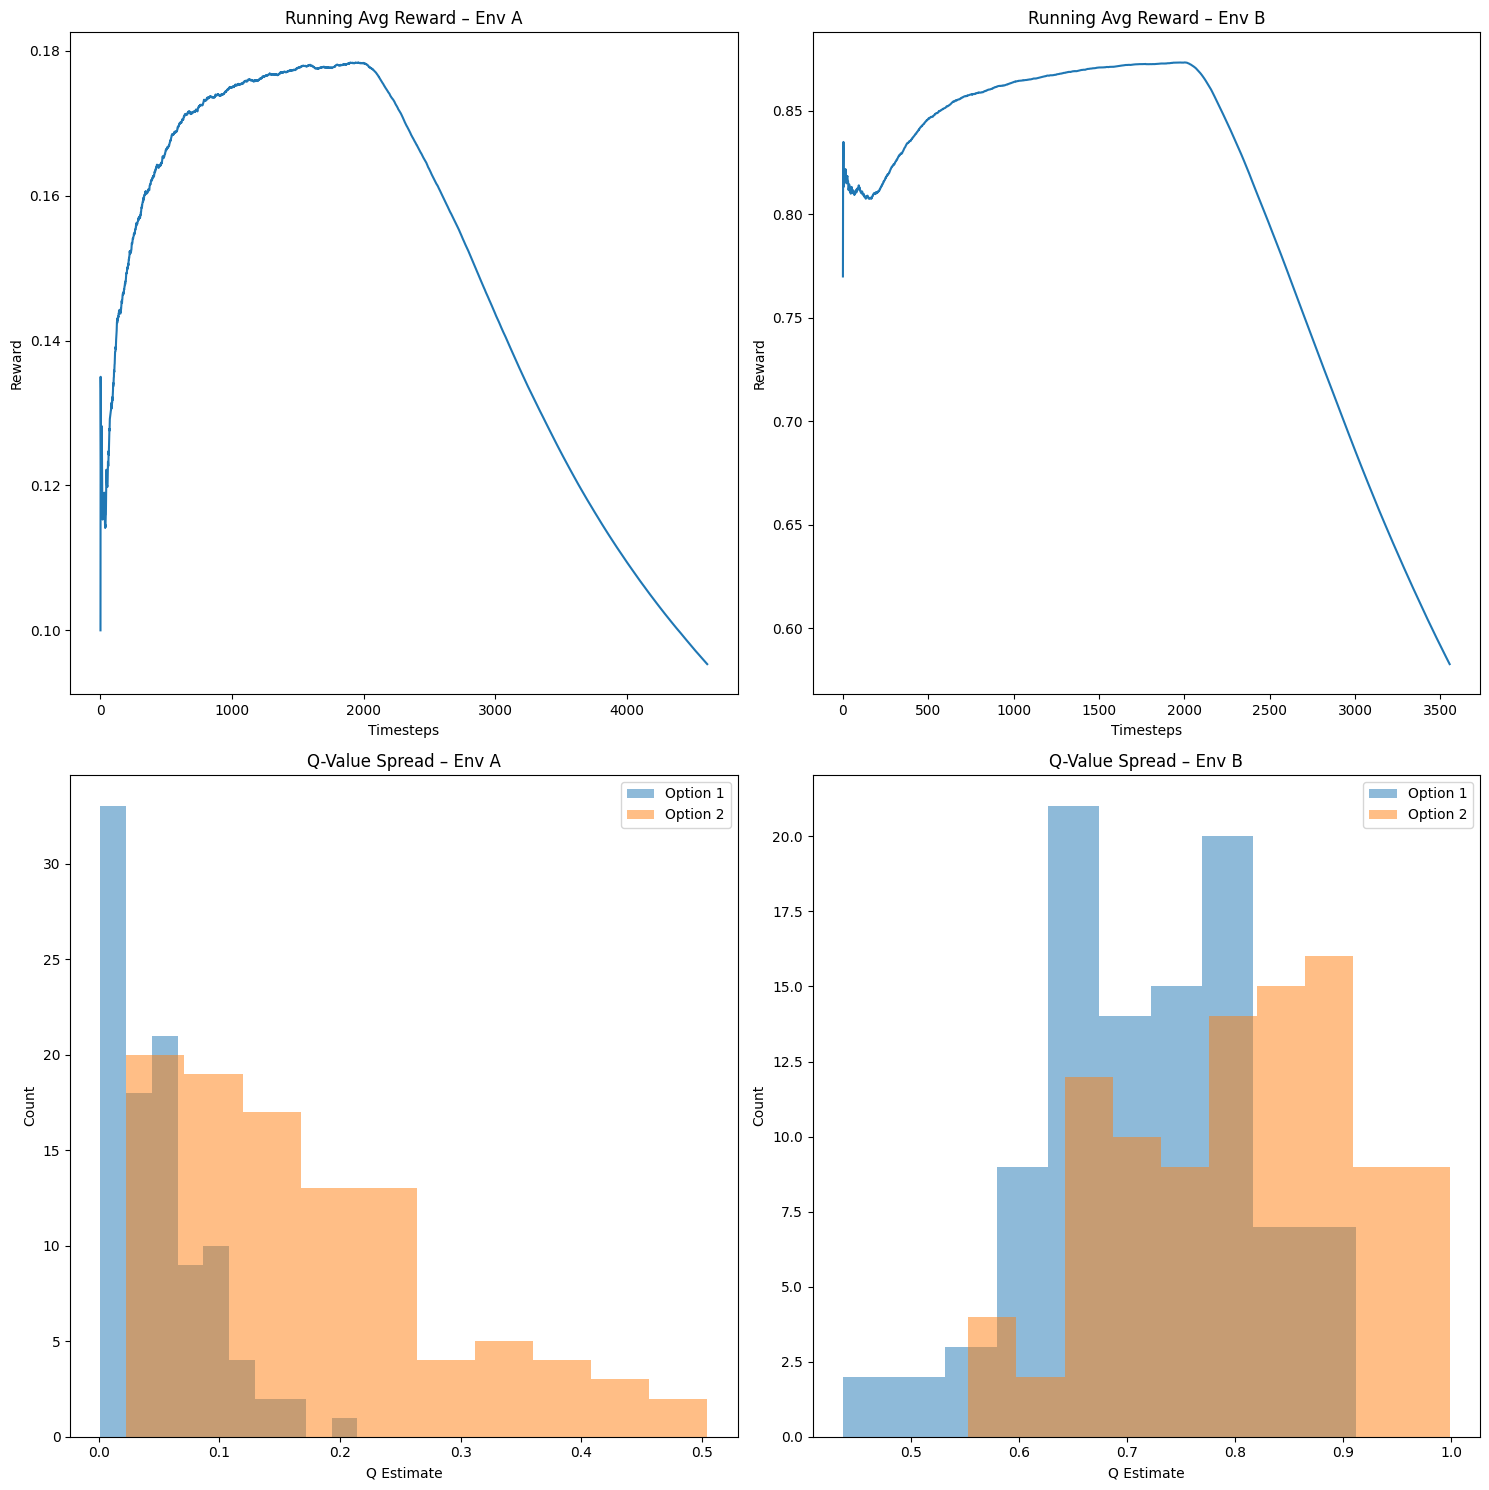

In [10]:
def visualize_summary(q_vals_A: np.ndarray, reward_seq_A: np.ndarray,
                      q_vals_B: np.ndarray, reward_seq_B: np.ndarray):

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    for idx, (reward_block, label) in enumerate([
        (reward_seq_A, "Env A"),
        (reward_seq_B, "Env B")
    ]):
        avg_over_time = np.nanmean(
            np.nancumsum(reward_block, axis=1) /
            np.arange(1, reward_block.shape[1] + 1),
            axis=0
        )

        axes[0, idx].plot(avg_over_time)
        axes[0, idx].set_title(f"Running Avg Reward – {label}")
        axes[0, idx].set_xlabel("Timesteps")
        axes[0, idx].set_ylabel("Reward")

    for idx, (q_block, label) in enumerate([
        (q_vals_A, "Env A"),
        (q_vals_B, "Env B")
    ]):
        axes[1, idx].hist(q_block[:, 0], alpha=0.5, label="Option 1")
        axes[1, idx].hist(q_block[:, 1], alpha=0.5, label="Option 2")
        axes[1, idx].set_title(f"Q-Value Spread – {label}")
        axes[1, idx].set_xlabel("Q Estimate")
        axes[1, idx].set_ylabel("Count")
        axes[1, idx].legend()

    plt.tight_layout()
    plt.show()



def launch():
    eps = 0.1
    arm_cnt = 2
    horizon = 10000
    runs = 100
    lr = 0.1

    # parameter bundles
    cfg_A = [(two_arm_bandit_A, eps, arm_cnt, horizon, lr) for _ in range(runs)]
    cfg_B = [(two_arm_bandit_B, eps, arm_cnt, horizon, lr) for _ in range(runs)]

    # run both setups in parallel
    with Pool() as executor:
        out_A = list(
            tqdm(
                executor.imap(run_experiment, cfg_A),
                total=runs,
                desc="Simulating A"
            )
        )
        out_B = list(
            tqdm(
                executor.imap(run_experiment, cfg_B),
                total=runs,
                desc="Simulating B"
            )
        )

    q_array_A = np.array([x[0] for x in out_A])
    reward_list_A = [x[1] for x in out_A]

    q_array_B = np.array([x[0] for x in out_B])
    reward_list_B = [x[1] for x in out_B]

    # pad runs to equal length
    max_A = max(len(seq) for seq in reward_list_A)
    max_B = max(len(seq) for seq in reward_list_B)

    reward_pad_A = pad_rewards(reward_list_A, max_A)
    reward_pad_B = pad_rewards(reward_list_B, max_B)

    # print summary
    for tag, qmat, rmat in [
        ("Env A", q_array_A, reward_pad_A),
        ("Env B", q_array_B, reward_pad_B)
    ]:
        mean_q = np.mean(qmat, axis=0)
        avg_r = np.nanmean(rmat, axis=0)
        cum_r = np.nanmean(
            np.nancumsum(rmat, axis=1) /
            np.arange(1, rmat.shape[1] + 1),
            axis=0
        )

        print(f"\n=== Summary for {tag} ===")
        print("Mean Q:", mean_q)
        print("Avg Reward:", np.nanmean(avg_r))
        print("Best Option:", np.argmax(mean_q) + 1)
        print("Final Cumulative Avg:", cum_r[-1])

    visualize_summary(q_array_A, reward_pad_A, q_array_B, reward_pad_B)



if __name__ == "__main__":
    launch()
